# _Music Genre Predictive Model_

## _Overview_
Music has been an important part of our lives since time immemorial. Every artist has a signature, making music a subjective art. We have scales/metrics to measure the quality of music. But, is it possible to train a machine learning model to predict the genre and quality of the music?

Currently, many music aggregator applications rely on machine learning to power their recommendation engine, and curate playlists. MachineHack is challenging data scientists and machine learning practitioners to build a highly scalable ML model for a music aggregator app (Company ABC) to accurately predict the genre of songs in the dataset.

About Dataset:

Training dataset: 17,996 rows with 17 columns 

Column details: artist name; track name; popularity; ‘danceability’; energy; key; loudness; mode; ‘speechiness’; ‘acousticness’; ‘instrumentalness’; liveness; valence; tempo; duration in milliseconds and time_signature. 

Target Variable: 'Class’ such as Rock, Indie, Alt, Pop, Metal, HipHop, Alt_Music, Blues, Acoustic/Folk, Instrumental, Country, Bollywood, 

Test dataset: 7,713 rows with 16 columns 

## Table of Contents

- [1 - Import Libraries and Load Data](#1)
- [2 - Basic Exploratory Data Analysis](#2)
    - [2.1 - An ingisht into Spotting Duplicate Records (Visible only when you split)](#2-1)
    - [2.2 - Harmonizing the Duration Feature Values](#2-2)
    
- [3 - Data Preparation](#3)
    - [3.1 - Handling Missing Values using Iterative Imputer](#3-1)
    - [3.2 - Label Encode the Artist Name](#3-2)
    - [3.3 - Handling Text Data in Track Name](#3-3)
        - [3.3.1 - Clean the Text Data](#3-3-1)
        - [3.3.2 - Generate Embeddings using Tensorflow Universal Sentence Encoder](#3-3-2)
        - [3.3.3 - t-SNE Non Linear Dimensionality Reduction using texthero package](#3-3-3)
        - [3.3.4 - Visualizing the Embeddings on 2Dimensions](#3-3-4)
- [ 4 - Conclusion](#4)


<a name='1'></a>
## _1 - Import Libraries_

In [1]:
#load the packages
import numpy as np
import pandas as pd
import os
#visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#consistent sized plots
from pylab import rcParams
rcParams['figure.figsize']=12,5
rcParams['axes.labelsize']=12
rcParams['xtick.labelsize']=12
rcParams['ytick.labelsize']=12
#display all columns 
pd.options.display.max_columns = None
#handle unwanted warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

## _Load the Data_

In [2]:
#load the data
train = pd.read_csv('Dataset_MGP_LHS/train.csv',delimiter=',',encoding='IBM862',engine='python')
test = pd.read_csv('Dataset_MGP_LHS/test.csv',delimiter=',',encoding='IBM862',engine='python')

In [3]:
#view the top rows
train.head()

Artist Name                             Track Name  Popularity  \
0             Bruno Mars  That's What I Like (feat. Gucci Mane)        60.0   
1                 Boston                           Hitch a Ride        54.0   
2          The Raincoats                     No Side to Fall In        35.0   
3                   Deno             Lingo (feat. J.I & Chunkz)        66.0   
4  Red Hot Chili Peppers      Nobody Weird Like Me - Remastered        53.0   

   danceability  energy   key  loudness  mode  speechiness  acousticness  \
0         0.854   0.564   1.0    -4.964     1       0.0485      0.017100   
1         0.382   0.814   3.0    -7.230     1       0.0406      0.001100   
2         0.434   0.614   6.0    -8.334     1       0.0525      0.486000   
3         0.853   0.597  10.0    -6.528     0       0.0555      0.021200   
4         0.167   0.975   2.0    -4.279     1       0.2160      0.000169   

   instrumentalness  liveness  valence    tempo  duration_in min/ms  \
0               NaN    0.0849   0.8990  134.071            234596.0   
1          0.004010    0.1010   0.5690  116.454            251733.0   
2          0.000196    0.3940   0.7870  147.681            109667.0   
3               NaN    0.1220   0.5690  107.033            173968.0   
4          0.016100    0.1720   0.0918  199.060            229960.0   

   time_signature  Class  
0               4      5  
1               4     10  
2               4      6  
3               4      5  
4               4     10

In [4]:
#check for duplicates 
len(train[train.duplicated()==True])

0

_According to this there are no duplicates. We would test this out more when the dataset is analyzed separately without the class labels. Key question is whether the same music can land up in different genres based on the values of the other features like energy, danceability. Perhaps yes, if it is an unplugged version or a remix version_

In [5]:
#trim artist name and track name of leading white spaces and convert to lower case
train['Artist Name'] = train['Artist Name'].str.strip()
test['Artist Name'] =  test['Artist Name'].str.strip()

train['Track Name'] = train['Track Name'].str.strip()
test['Track Name'] =  test['Track Name'].str.strip()

train['Artist Name'] = train['Artist Name'].str.lower()
test['Artist Name'] =  test['Artist Name'].str.lower()

train['Track Name'] = train['Track Name'].str.lower()
test['Track Name'] =  test['Track Name'].str.lower()

<a name='2'></a>
## _Basic Exploratory Data Analysis_

In [6]:
#check the info 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

- _There are 17,996 observations in the dataset_
- _Features "key" and "intrumentalness" have missing values_
- _Artist Name and Track Name are the only string features. Remaining all the features are of numerical type_

In [7]:
#check the basic stats
train.describe().transpose()

count           mean            std        min  \
Popularity          17568.0      44.512124      17.426928   1.000000   
danceability        17996.0       0.543433       0.166268   0.059600   
energy              17996.0       0.662777       0.235373   0.000020   
key                 15982.0       5.952447       3.196854   1.000000   
loudness            17996.0      -7.910660       4.049151 -39.952000   
mode                17996.0       0.636753       0.480949   0.000000   
speechiness         17996.0       0.079707       0.083576   0.022500   
acousticness        17996.0       0.247082       0.310632   0.000000   
instrumentalness    13619.0       0.177562       0.304048   0.000001   
liveness            17996.0       0.196170       0.159212   0.011900   
valence             17996.0       0.486208       0.240195   0.018300   
tempo               17996.0     122.623294      29.571527  30.557000   
duration_in min/ms  17996.0  200744.458851  111989.127131   0.501650   
time_signature      17996.0       3.924039       0.361618   1.000000   
Class               17996.0       6.695821       3.206073   0.000000   

                              25%           50%           75%          max  
Popularity              33.000000      44.00000      56.00000      100.000  
danceability             0.432000       0.54500       0.65900        0.989  
energy                   0.509000       0.70000       0.86000        1.000  
key                      3.000000       6.00000       9.00000       11.000  
loudness                -9.538000      -7.01600      -5.18900        1.355  
mode                     0.000000       1.00000       1.00000        1.000  
speechiness              0.034800       0.04740       0.08300        0.955  
acousticness             0.004300       0.08140       0.43400        0.996  
instrumentalness         0.000089       0.00391       0.20000        0.996  
liveness                 0.097500       0.12900       0.25800        1.000  
valence                  0.297000       0.48100       0.67200        0.986  
tempo                   99.620750     120.06550     141.96925      217.416  
duration_in min/ms  166337.000000  209160.00000  252490.00000  1477187.000  
time_signature           4.000000       4.00000       4.00000        5.000  
Class                    5.000000       8.00000      10.00000       10.000

In [8]:
#check the various classes / labels
train['Class'].unique()

array([ 5, 10,  6,  2,  4,  8,  9,  3,  7,  1,  0], dtype=int64)

In [9]:
#check the number of different class types
train['Class'].value_counts().sort_values(ascending=False)

10    4949
6     2587
9     2524
8     1854
5     1447
1     1373
2     1272
0      625
7      576
3      402
4      387
Name: Class, dtype: int64

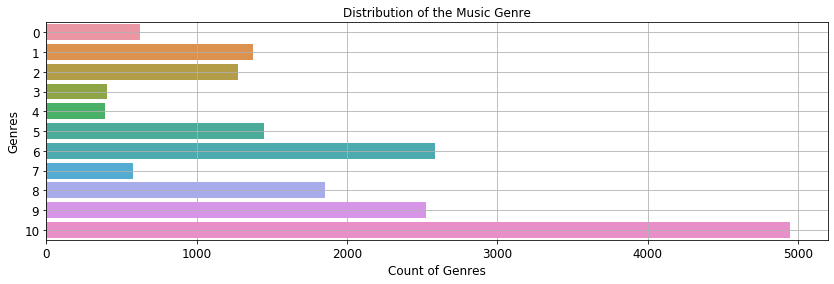

In [10]:
#plot of the Class / Music Genre count
plt.figure(figsize=(14,4))
sns.countplot(y=train['Class'])
plt.title('Distribution of the Music Genre')
plt.ylabel('Genres')
plt.xlabel('Count of Genres')
plt.grid()
plt.show()

_This is an imbalanced dataset. For model training, it would be appropriate to split based on stratification on the Class label_

<b> _Before proceeding further, lets split the dataset into train and dev set. While we would explore the train set, the dev set would be used to validate the model performance and generalization_ </b>

In [11]:
#import train test split and create the X features and y labels 
from sklearn.model_selection import train_test_split
X = train.drop('Class',axis=1)
y = train[['Class']]
test_size = 0.1
seed = 41

#split the dataset
X_train,X_dev,y_train,y_dev = train_test_split(X,y,test_size=test_size,random_state=seed,stratify=train['Class'],shuffle=True)

In [12]:
#check top rows of X_train
X_train.head(2)

Artist Name              Track Name  Popularity  danceability  \
15417            friedberg                   lizzy        40.0         0.500   
8331   deep blue something  breakfast at tiffany's        72.0         0.622   

       energy  key  loudness  mode  speechiness  acousticness  \
15417   0.817  1.0    -5.876     1       0.0457      0.000255   
8331    0.829  2.0    -5.548     1       0.0290      0.110000   

       instrumentalness  liveness  valence    tempo  duration_in min/ms  \
15417            0.0922    0.1360    0.480  130.978            230127.0   
8331                NaN    0.0954    0.539  110.367            257373.0   

       time_signature  
15417               4  
8331                4

In [13]:
y_train.head(2)

Class
15417      9
8331      10

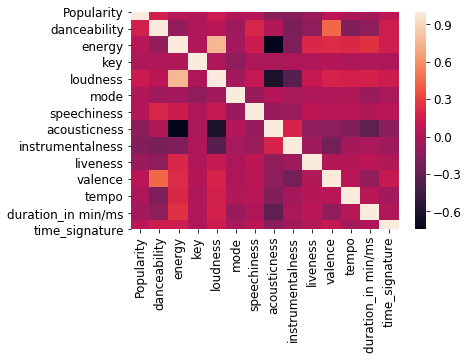

In [14]:
#check the correlation map
sns.heatmap(X_train.corr())
plt.show()

- _There is correlation between some of the features. Example loudness, energy and acouticness are highly correlated_
- _Similarly danceability and valence is also correlated_

Using a dimensionality reduction technique would help to reduce the features before feeding into the model.

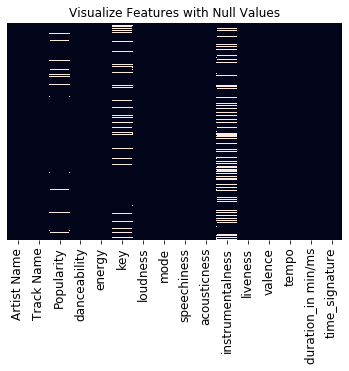

In [15]:
#check for the null values
sns.heatmap(X_train.isna(),yticklabels=False,cbar=False)
plt.title('Visualize Features with Null Values')
plt.show()


<a name='2-1'></a>
## _An insight into spotting the Duplicate records_

In [16]:
#check the top 10 artists in the dataset 
X_train['Artist Name'].value_counts().sort_values(ascending=False)[:10]

backstreet boys    62
westlife           53
britney spears     48
eyal golan         47
omer adam          46
shlomo artzi       36
arik einstein      33
itay levi          33
dudu aharon        31
hadag nahash       30
Name: Artist Name, dtype: int64

In [17]:
#check the unique track names in the dataset
X_train['Track Name'].nunique()

13697

In [18]:
len(X_train)

16196

_The number of unique tracks is lesser than the total number of rows in the X_train. There are either duplicate tracks or two artist seem to have a similar track name_

In [19]:
#list down the track names in the descending order of their frequency
X_train['Track Name'].value_counts().sort_values(ascending=False)

runaway                          8
fire                             8
dreams                           8
home                             7
ghost                            7
                                ..
good rockin' daddy               1
let a man do what he wanna do    1
one last embrace                 1
γקך├¬γקך├┤γקך├▒γקך├»γקך├╝        1
while my guitar gently weeps     1
Name: Track Name, Length: 13697, dtype: int64

In [20]:
#check one of the repeated tracks
X_train[X_train['Track Name']=='runaway']

Artist Name Track Name  Popularity  danceability  energy   key  \
6585   oliver malcolm    runaway        18.0         0.691   0.753  11.0   
15513          aurora    runaway        89.0         0.422   0.302  11.0   
9916           aurora    runaway        77.0         0.521   0.277  11.0   
8025           aurora    runaway        89.0         0.422   0.302  11.0   
17713     castlecomer    runaway        37.0         0.286   0.749   4.0   
9102           aurora    runaway        89.0         0.422   0.302  11.0   
7993   oliver malcolm    runaway         NaN         0.691   0.753  11.0   
2507      del shannon    runaway        60.0         0.594   0.533  10.0   

       loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
6585     -6.098     0       0.0634      0.000266          0.310000     0.107   
15513    -9.214     1       0.0372      0.629000          0.000078     0.104   
9916    -10.340     1       0.0356      0.634000          0.000071     0.103   
8025     -9.214     1       0.0372      0.629000          0.000078     0.104   
17713    -7.752     1       0.0500      0.005430               NaN     0.312   
9102     -9.214     1       0.0372      0.629000          0.000078     0.104   
7993     -6.098     0       0.0634      0.000266          0.310000     0.107   
2507     -7.993     0       0.0438      0.153000          0.000015     0.172   

       valence    tempo  duration_in min/ms  time_signature  
6585     0.886  157.903       125689.000000               4  
15513    0.123  114.089       248827.000000               4  
9916     0.130  115.010            4.147117               4  
8025     0.123  114.089       248827.000000               4  
17713    0.425  173.968       203605.000000               4  
9102     0.123  114.089       248827.000000               4  
7993     0.886  157.903       125689.000000               4  
2507     0.729   78.552            2.288450               4

- _There are clear duplicate records in the dataset. Observe the row index 15513 and 9102_
- _The same track name is repeated for different artists as well.One way to handle such instance would be to combine the artist name and the track name together_

In [21]:
#check another of repeated tracks to spot any new observation .. 
X_train[X_train['Track Name']=='dreams']

Artist Name Track Name  Popularity  danceability  energy  \
4863            fleetwood mac     dreams        85.0         0.828   0.492   
6806   irish women in harmony     dreams        48.0         0.558   0.475   
463                      beck     dreams        59.0         0.582   0.938   
1301          langston hughes     dreams         8.0         0.745   0.102   
16070                 d smoke     dreams        40.0         0.772   0.449   
10775               van halen     dreams        60.0         0.455   0.758   
4155                 the game     dreams        58.0         0.630   0.780   
320               sense field     dreams        23.0         0.505   0.659   

       key  loudness  mode  speechiness  acousticness  instrumentalness  \
4863   NaN    -9.744     1       0.0276      0.064400          0.004280   
6806   4.0    -8.623     1       0.0282      0.516000          0.000006   
463    1.0    -5.726     0       0.0392      0.000733          0.020200   
1301   2.0   -19.061     1       0.9370      0.982000               NaN   
16070  1.0   -10.324     1       0.3660      0.457000          0.000019   
10775  NaN   -11.361     1       0.0454      0.223000          0.000003   
4155   6.0    -5.353     1       0.2210      0.004990               NaN   
320    3.0   -12.146     1       0.0256      0.032100          0.009860   

       liveness  valence    tempo  duration_in min/ms  time_signature  
4863     0.1280    0.789  120.151       257800.000000               4  
6806     0.1070    0.344  116.924            4.150167               4  
463      0.0841    0.800  113.999       314487.000000               4  
1301     0.1240    0.371   88.247        57443.000000               4  
16070    0.3430    0.561   94.736       213438.000000               4  
10775    0.0986    0.540  141.304       294000.000000               4  
4155     0.2060    0.281  155.779       286453.000000               4  
320      0.1160    0.461  101.530       262600.000000               1

In [22]:
#get rid of the absolute duplicate records from the dataset 
indices_duplicated_xtrain = X_train[X_train.duplicated(keep='first')==True].index
indices_duplicated_xdev = X_dev[X_dev.duplicated(keep='first')==True].index

In [23]:
warnings.filterwarnings(action='ignore')

#drop the duplicates
X_train.drop_duplicates(keep='first',inplace=True)
X_dev.drop_duplicates(keep='first',inplace=True)

In [24]:
indices_retain_xtrain = X_train.index
indices_retain_xdev = X_dev.index

In [25]:
indices_retain_xtrain

Int64Index([15417,  8331, 12314,  4996,   971,  8537,  6572, 11068,  2761,
              635,
            ...
             6989,  6576,  2303,    67,  8230, 13222,  8840, 10178,  9176,
              745],
           dtype='int64', length=14818)

In [26]:
#remove the corresponding labels from y_train and y_dev
y_train = y_train.loc[indices_retain_xtrain]
y_dev = y_dev.loc[indices_retain_xdev]

In [27]:
#check the length of the X_train and y_train --> one way to confirm 
len(X_train), len(y_train)

(14818, 14818)

In [28]:
#check the match in indices --> first few indices, a more robust algo can also be written
print(X_train.index[:10])
print(y_train.index[:10])

Int64Index([15417, 8331, 12314, 4996, 971, 8537, 6572, 11068, 2761, 635], dtype='int64')
Int64Index([15417, 8331, 12314, 4996, 971, 8537, 6572, 11068, 2761, 635], dtype='int64')


In [29]:
X_train.head()

Artist Name              Track Name  Popularity  danceability  \
15417            friedberg                   lizzy        40.0         0.500   
8331   deep blue something  breakfast at tiffany's        72.0         0.622   
12314         spin doctors        what time is it?        38.0         0.544   
4996            josh fudge        summer something        31.0         0.602   
971                nascent           bottom dollar        26.0         0.654   

       energy   key  loudness  mode  speechiness  acousticness  \
15417   0.817   1.0    -5.876     1       0.0457      0.000255   
8331    0.829   2.0    -5.548     1       0.0290      0.110000   
12314   0.885   7.0    -9.975     1       0.0732      0.038300   
4996    0.667  11.0    -6.293     1       0.0264      0.392000   
971     0.780   1.0    -4.612     1       0.0676      0.023900   

       instrumentalness  liveness  valence    tempo  duration_in min/ms  \
15417            0.0922    0.1360    0.480  130.978            230127.0   
8331                NaN    0.0954    0.539  110.367            257373.0   
12314            0.0121    0.3690    0.208  115.302            289893.0   
4996             0.9350    0.1350    0.448  122.986            194634.0   
971              0.0523    0.2390    0.626  148.149            184288.0   

       time_signature  
15417               4  
8331                4  
12314               4  
4996                4  
971                 4

_The same artist name and same track name could result due to date merging from different apps where the music is listed. It is unlikely that the same artist may have the same track name. One possibility is if the same track is listed again with a different musical background. For example it is very common to spot unplugged version, altered version with higher beats, remix etc. These differences can be noiticed with the other features of the dataset like energy, danceability, valence, loudness and acousticness. A musician would be better positioned to spot the differences_

In [30]:
X_train['Track Name'].value_counts().sort_values(ascending=False)

dreams                          8
ghost                           7
landslide                       6
runaway                         6
cry                             6
                               ..
seyyah                          1
glycerine - remastered          1
two hands                       1
dissolve                        1
while my guitar gently weeps    1
Name: Track Name, Length: 13697, dtype: int64

In [31]:
X_train[X_train['Track Name']=='Runaway']

Empty DataFrame
Columns: [Artist Name, Track Name, Popularity, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_in min/ms, time_signature]
Index: []

<a name='2-2'></a>
## _Harmonizing Duration Feature_

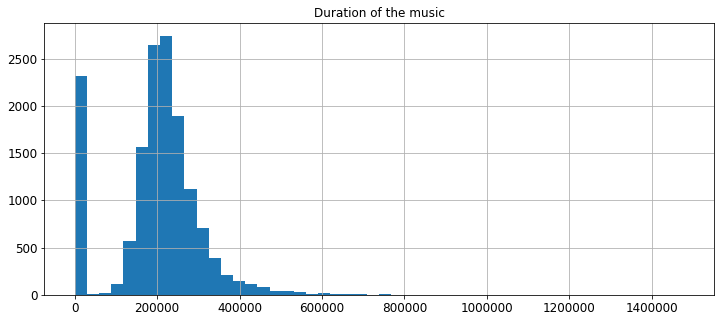

In [32]:
plt.figure(figsize=(12,5))
plt.hist(X_train['duration_in min/ms'],bins=50)
plt.title('Duration of the music')
plt.grid()
plt.show()

_The duration is either in minutes or in milliseconds and hence the histogram is so highly skewed. It would be better to convert them to a single unit measure in minutes_

In [33]:
def duration_min(duration):
    '''This function will convert the millisecond duration music in minutes'''
    if duration > 1000: #1000 is a safe lower limit
        duration = duration / 60000
    return duration

In [34]:
#convert the duration in minutes
X_train['duration_in min/ms'] = X_train['duration_in min/ms'].apply(duration_min)

In [35]:
#convert the duration in minutes in the dev set
X_dev['duration_in min/ms'] = X_dev['duration_in min/ms'].apply(duration_min)

In [36]:
X_train.head(2)

Artist Name              Track Name  Popularity  danceability  \
15417            friedberg                   lizzy        40.0         0.500   
8331   deep blue something  breakfast at tiffany's        72.0         0.622   

       energy  key  loudness  mode  speechiness  acousticness  \
15417   0.817  1.0    -5.876     1       0.0457      0.000255   
8331    0.829  2.0    -5.548     1       0.0290      0.110000   

       instrumentalness  liveness  valence    tempo  duration_in min/ms  \
15417            0.0922    0.1360    0.480  130.978             3.83545   
8331                NaN    0.0954    0.539  110.367             4.28955   

       time_signature  
15417               4  
8331                4

In [37]:
#apply the changes in the test dataset
test['duration_in min/ms'] = test['duration_in min/ms'].apply(duration_min)

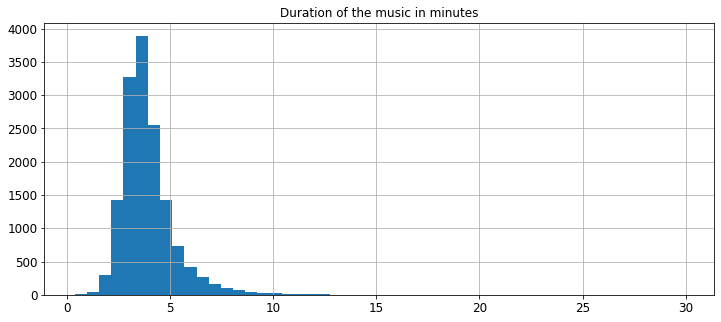

In [38]:
plt.figure(figsize=(12,5))
plt.hist(X_train['duration_in min/ms'],bins=50)
plt.title('Duration of the music in minutes')
plt.grid()
plt.show()

In [39]:
#select only the numerical features
numerical_features =  X_train.select_dtypes(exclude='object')

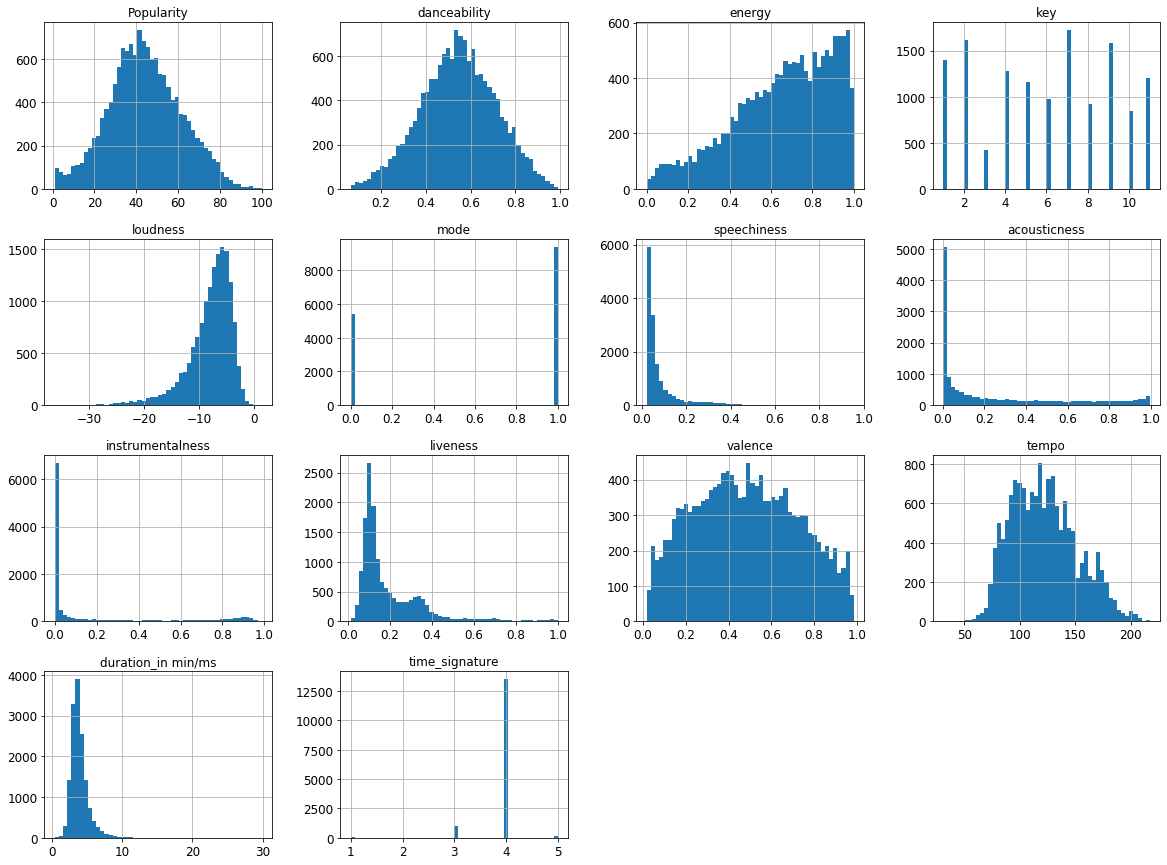

In [40]:
#create histogram of all the numerical features 
numerical_features.hist(bins=50, figsize=(20,15))
plt.show()

In [41]:
categorical_features = X_train.select_dtypes(include='object').columns.tolist()

In [42]:
categorical_features

['Artist Name', 'Track Name']

In [43]:
X_train['mode'].value_counts()

1    9413
0    5405
Name: mode, dtype: int64

In [44]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14818 entries, 15417 to 745
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         14818 non-null  object 
 1   Track Name          14818 non-null  object 
 2   Popularity          14459 non-null  float64
 3   danceability        14818 non-null  float64
 4   energy              14818 non-null  float64
 5   key                 13131 non-null  float64
 6   loudness            14818 non-null  float64
 7   mode                14818 non-null  int64  
 8   speechiness         14818 non-null  float64
 9   acousticness        14818 non-null  float64
 10  instrumentalness    11080 non-null  float64
 11  liveness            14818 non-null  float64
 12  valence             14818 non-null  float64
 13  tempo               14818 non-null  float64
 14  duration_in min/ms  14818 non-null  float64
 15  time_signature      14818 non-null  int64  
dtypes:

In [45]:
#check how many similar track names still appear
X_train['Track Name'].value_counts().sort_values(ascending=False)

dreams                          8
ghost                           7
landslide                       6
runaway                         6
cry                             6
                               ..
seyyah                          1
glycerine - remastered          1
two hands                       1
dissolve                        1
while my guitar gently weeps    1
Name: Track Name, Length: 13697, dtype: int64

In [46]:
X_train['Artist Name'].nunique()

8543

<a name='3'></a>
## _Data Preparation_
***

<a name='3-1'></a>
## _Label Encode the Artist Name_
_Test dataset contains artist names not in the train dataset and hence the below approach is a workaround. This is not the preferred way to label encode when launching model into production. In real scenario we may not even know what the test data is going to contain. Handling of this scenario is beyond the scope of this notebook_ 

In [47]:
#label encode the categorical features
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train_cat_features = ['Artist Name']
for col in train_cat_features:
    encoder.fit(list(X_train[col].values) + list(X_dev[col].values) + list(test[col].values))
    X_train[col] = encoder.transform(list(X_train[col].values))
    X_dev[col] =   encoder.transform(list(X_dev[col].values))
    test[col] =    encoder.transform(list(test[col].values))

In [48]:
X_train.head(3)

Artist Name              Track Name  Popularity  danceability  energy  \
15417         3504                   lizzy        40.0         0.500   0.817   
8331          2429  breakfast at tiffany's        72.0         0.622   0.829   
12314         9049        what time is it?        38.0         0.544   0.885   

       key  loudness  mode  speechiness  acousticness  instrumentalness  \
15417  1.0    -5.876     1       0.0457      0.000255            0.0922   
8331   2.0    -5.548     1       0.0290      0.110000               NaN   
12314  7.0    -9.975     1       0.0732      0.038300            0.0121   

       liveness  valence    tempo  duration_in min/ms  time_signature  
15417    0.1360    0.480  130.978             3.83545               4  
8331     0.0954    0.539  110.367             4.28955               4  
12314    0.3690    0.208  115.302             4.83155               4

In [49]:
X_dev.head(3)

Artist Name                   Track Name  Popularity  danceability  \
3694          7489                        alive        75.0         0.284   
15022         2329  let's dance - 1999 remaster        15.0         0.619   
7356          9070                       tennis        27.0         0.415   

       energy   key  loudness  mode  speechiness  acousticness  \
3694    0.875  11.0    -6.069     0       0.0422      0.007520   
15022   0.703  10.0    -9.414     0       0.0525      0.003880   
7356    0.766   1.0    -9.739     1       0.1420      0.000076   

       instrumentalness  liveness  valence    tempo  duration_in min/ms  \
3694           0.000461     0.402    0.595   75.009            5.681783   
15022          0.205000     0.163    0.709  115.043            7.618883   
7356           0.872000     0.376    0.271  159.923            5.100000   

       time_signature  
3694                4  
15022               4  
7356                4

In [50]:
test.head(2)

Artist Name                    Track Name  Popularity  danceability  \
0         2329  space oddity - 2015 remaster        73.0         0.310   
1         2136           essence of creation        34.0         0.511   

   energy  key  loudness  mode  speechiness  acousticness  instrumentalness  \
0   0.403  NaN   -13.664     1       0.0326        0.0726          0.000093   
1   0.955  1.0    -5.059     1       0.1290        0.0004          0.000009   

   liveness  valence    tempo  duration_in min/ms  time_signature  
0     0.139    0.466  134.480             5.30045               4  
1     0.263    0.291  151.937             3.67355               4

<a name='3-2'></a>
## _Handling the missing values using Iterative Imputer_

In [51]:
X_train.columns

Index(['Artist Name', 'Track Name', 'Popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_in min/ms', 'time_signature'],
      dtype='object')

In [52]:
numeric_columns = ['Popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_in min/ms', 'time_signature']

In [53]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [54]:
#carve out only the numerical features 
X_train_num = X_train[numeric_columns]
X_dev_num = X_dev[numeric_columns]
test_num = test[numeric_columns]

In [55]:
#impute the values in the numerical features
imputer = IterativeImputer()
train_imputed = imputer.fit_transform(X_train_num)
X_train_num = pd.DataFrame(data=train_imputed,columns=numeric_columns)

In [56]:
#apply the impute transform on the dev and the test set
dev_imputed = imputer.transform(X_dev_num)
test_imputed = imputer.transform(test_num)

X_dev_num = pd.DataFrame(data=dev_imputed,columns=numeric_columns)
test_num = pd.DataFrame(data=test_imputed,columns=numeric_columns)

In [57]:
X_train.drop(numeric_columns,axis=1,inplace=True)
X_dev.drop(numeric_columns,axis=1,inplace=True)
test.drop(numeric_columns,axis=1,inplace=True)

In [58]:
X_train

Artist Name                                     Track Name
15417         3504                                          lizzy
8331          2429                         breakfast at tiffany's
12314         9049                               what time is it?
4996          4953                               summer something
971           6915                                  bottom dollar
...            ...                                            ...
13222         3651       supper's ready - digital remastered 2008
8840          5153                                       underdog
10178         6008  turn off the news (build a garden) - acoustic
9176          6245                                          drown
745          10784                               magnet and steel

[14818 rows x 2 columns]

In [59]:
#add the imputed columns
for feature in numeric_columns:
    X_train[feature] = X_train_num[feature].values
    X_dev[feature] = X_dev_num[feature].values
    test[feature] = test_num[feature].values    

In [60]:
X_train.head()

Artist Name              Track Name  Popularity  danceability  energy  \
15417         3504                   lizzy        40.0         0.500   0.817   
8331          2429  breakfast at tiffany's        72.0         0.622   0.829   
12314         9049        what time is it?        38.0         0.544   0.885   
4996          4953        summer something        31.0         0.602   0.667   
971           6915           bottom dollar        26.0         0.654   0.780   

        key  loudness  mode  speechiness  acousticness  instrumentalness  \
15417   1.0    -5.876   1.0       0.0457      0.000255          0.092200   
8331    2.0    -5.548   1.0       0.0290      0.110000          0.058242   
12314   7.0    -9.975   1.0       0.0732      0.038300          0.012100   
4996   11.0    -6.293   1.0       0.0264      0.392000          0.935000   
971     1.0    -4.612   1.0       0.0676      0.023900          0.052300   

       liveness  valence    tempo  duration_in min/ms  time_signature  
15417    0.1360    0.480  130.978            3.835450             4.0  
8331     0.0954    0.539  110.367            4.289550             4.0  
12314    0.3690    0.208  115.302            4.831550             4.0  
4996     0.1350    0.448  122.986            3.243900             4.0  
971      0.2390    0.626  148.149            3.071467             4.0

In [61]:
X_train.isna().sum().sum()

0

In [62]:
X_dev.isna().sum().sum()

0

In [63]:
test.isna().sum().sum()

0

<a name='3-3'></a>
## _Handle the text field Track Name_

- _Clean the text_ 
- _Apply Universal Sentence Encoder Large to generate the embeddings_

<a name='3-3-1'></a>
### _Clean the Text_

In [64]:
import string
#remove the special characters / punctuations from the track name
X_train['Track Name'] = X_train['Track Name'].str.replace('[{}]'.format(string.punctuation),'')

In [65]:
X_dev['Track Name'] = X_dev['Track Name'].str.replace('[{}]'.format(string.punctuation),'')
test['Track Name'] = test['Track Name'].str.replace('[{}]'.format(string.punctuation),'')

In [66]:
#remove all the digits
X_train['Track Name'] = X_train['Track Name'].str.replace(r'[\d]*','',regex=True)
X_dev['Track Name'] = X_dev['Track Name'].str.replace(r'[\d]*','',regex=True)
test['Track Name'] = test['Track Name'].str.replace(r'[\d]*','',regex=True)

In [67]:
X_train.head()

Artist Name             Track Name  Popularity  danceability  energy  \
15417         3504                  lizzy        40.0         0.500   0.817   
8331          2429  breakfast at tiffanys        72.0         0.622   0.829   
12314         9049        what time is it        38.0         0.544   0.885   
4996          4953       summer something        31.0         0.602   0.667   
971           6915          bottom dollar        26.0         0.654   0.780   

        key  loudness  mode  speechiness  acousticness  instrumentalness  \
15417   1.0    -5.876   1.0       0.0457      0.000255          0.092200   
8331    2.0    -5.548   1.0       0.0290      0.110000          0.058242   
12314   7.0    -9.975   1.0       0.0732      0.038300          0.012100   
4996   11.0    -6.293   1.0       0.0264      0.392000          0.935000   
971     1.0    -4.612   1.0       0.0676      0.023900          0.052300   

       liveness  valence    tempo  duration_in min/ms  time_signature  
15417    0.1360    0.480  130.978            3.835450             4.0  
8331     0.0954    0.539  110.367            4.289550             4.0  
12314    0.3690    0.208  115.302            4.831550             4.0  
4996     0.1350    0.448  122.986            3.243900             4.0  
971      0.2390    0.626  148.149            3.071467             4.0

In [68]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [69]:
from nltk.tokenize import word_tokenize
def rem_stopword(text):
    '''function to remove the stopwords from a text column of a dataframe'''
    words = ' '.join([word for word in word_tokenize(text) if word not in stop_words])
    return words

In [70]:
X_train['Track Name'] = X_train['Track Name'].apply(rem_stopword)

In [71]:
X_dev['Track Name'] = X_dev['Track Name'].apply(rem_stopword)
test['Track Name'] = test['Track Name'].apply(rem_stopword)

In [72]:
X_train.head(3)

Artist Name          Track Name  Popularity  danceability  energy  key  \
15417         3504               lizzy        40.0         0.500   0.817  1.0   
8331          2429  breakfast tiffanys        72.0         0.622   0.829  2.0   
12314         9049                time        38.0         0.544   0.885  7.0   

       loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
15417    -5.876   1.0       0.0457      0.000255          0.092200    0.1360   
8331     -5.548   1.0       0.0290      0.110000          0.058242    0.0954   
12314    -9.975   1.0       0.0732      0.038300          0.012100    0.3690   

       valence    tempo  duration_in min/ms  time_signature  
15417    0.480  130.978             3.83545             4.0  
8331     0.539  110.367             4.28955             4.0  
12314    0.208  115.302             4.83155             4.0

<a name='3-3-2'></a>
## _Generate embeddings using tensorflow hub universal sentence encoder_


In [73]:
#!pip install --upgrade tensorflow_hub
import tensorflow_hub as hub
#download the model
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [74]:
#generate embeddings
embeddings = embed(X_train['Track Name'])
#create list from np arrays
use= np.array(embeddings).tolist()
#add lists as dataframe column
X_train['Track Name Embeddings'] = use
#check dataframe
X_train.head(2)

Artist Name          Track Name  Popularity  danceability  energy  key  \
15417         3504               lizzy        40.0         0.500   0.817  1.0   
8331          2429  breakfast tiffanys        72.0         0.622   0.829  2.0   

       loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
15417    -5.876   1.0       0.0457      0.000255          0.092200    0.1360   
8331     -5.548   1.0       0.0290      0.110000          0.058242    0.0954   

       valence    tempo  duration_in min/ms  time_signature  \
15417    0.480  130.978             3.83545             4.0   
8331     0.539  110.367             4.28955             4.0   

                                   Track Name Embeddings  
15417  [0.04651562497019768, 0.011862586252391338, -0...  
8331   [-0.014302350580692291, -0.03048250451683998, ...

In [75]:
#generate embeddings
embeddings = embed(X_dev['Track Name'])
#create list from np arrays
use= np.array(embeddings).tolist()
#add lists as dataframe column
X_dev['Track Name Embeddings'] = use
#check dataframe
X_dev.head(2)

Artist Name           Track Name  Popularity  danceability  energy  \
3694          7489                alive        75.0         0.284   0.875   
15022         2329  lets dance remaster        15.0         0.619   0.703   

        key  loudness  mode  speechiness  acousticness  instrumentalness  \
3694   11.0    -6.069   0.0       0.0422       0.00752          0.000461   
15022  10.0    -9.414   0.0       0.0525       0.00388          0.205000   

       liveness  valence    tempo  duration_in min/ms  time_signature  \
3694      0.402    0.595   75.009            5.681783             4.0   
15022     0.163    0.709  115.043            7.618883             4.0   

                                   Track Name Embeddings  
3694   [-0.005892008077353239, -0.04109394550323486, ...  
15022  [0.042615991085767746, 0.053283967077732086, 0...

In [76]:
#generate embeddings
embeddings = embed(test['Track Name'])
#create list from np arrays
use= np.array(embeddings).tolist()
#add lists as dataframe column
test['Track Name Embeddings'] = use
#check dataframe
test.head(2)

Artist Name             Track Name  Popularity  danceability  energy  \
0         2329  space oddity remaster        73.0         0.310   0.403   
1         2136       essence creation        34.0         0.511   0.955   

        key  loudness  mode  speechiness  acousticness  instrumentalness  \
0  5.801341   -13.664   1.0       0.0326        0.0726          0.000093   
1  1.000000    -5.059   1.0       0.1290        0.0004          0.000009   

   liveness  valence    tempo  duration_in min/ms  time_signature  \
0     0.139    0.466  134.480             5.30045             4.0   
1     0.263    0.291  151.937             3.67355             4.0   

                               Track Name Embeddings  
0  [-0.010036312974989414, 0.021080292761325836, ...  
1  [0.008051518350839615, -0.03247518464922905, -...

<a name='3-3-3'></a>
## _t-SNE Non Linear Dimensionality Reduction using texthero_

In [77]:
#!pip install texthero

In [78]:
#load texthero
import texthero as hero

In [79]:
X_train['tsneuse'] = hero.tsne(X_train['Track Name Embeddings'])

In [80]:
X_train.head(2)

Artist Name          Track Name  Popularity  danceability  energy  key  \
15417         3504               lizzy        40.0         0.500   0.817  1.0   
8331          2429  breakfast tiffanys        72.0         0.622   0.829  2.0   

       loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
15417    -5.876   1.0       0.0457      0.000255          0.092200    0.1360   
8331     -5.548   1.0       0.0290      0.110000          0.058242    0.0954   

       valence    tempo  duration_in min/ms  time_signature  \
15417    0.480  130.978             3.83545             4.0   
8331     0.539  110.367             4.28955             4.0   

                                   Track Name Embeddings  \
15417  [0.04651562497019768, 0.011862586252391338, -0...   
8331   [-0.014302350580692291, -0.03048250451683998, ...   

                                         tsneuse  
15417  [-37.990440368652344, -32.27280044555664]  
8331    [26.782899856567383, -51.19173049926758]

<a name='3-3-4'></a>
## _Visualize Embeddings_

In [81]:
#create scatter plot of uni. sent. enc.
hero.scatterplot(X_train, col='tsneuse',title="Track Name on 2-Dimension Embedding using Universal Sentence Encoder",color='Popularity')

In [82]:
#perform dimensionality reduction using t-SNE on the dev and the test set 
X_dev['tsneuse'] = hero.tsne(X_dev['Track Name Embeddings'])
test['tsneuse'] = hero.tsne(test['Track Name Embeddings'])

In [83]:
X_train['tsneuse'].dtype

dtype('O')

In [84]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14818 entries, 15417 to 745
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Artist Name            14818 non-null  int64  
 1   Track Name             14818 non-null  object 
 2   Popularity             14818 non-null  float64
 3   danceability           14818 non-null  float64
 4   energy                 14818 non-null  float64
 5   key                    14818 non-null  float64
 6   loudness               14818 non-null  float64
 7   mode                   14818 non-null  float64
 8   speechiness            14818 non-null  float64
 9   acousticness           14818 non-null  float64
 10  instrumentalness       14818 non-null  float64
 11  liveness               14818 non-null  float64
 12  valence                14818 non-null  float64
 13  tempo                  14818 non-null  float64
 14  duration_in min/ms     14818 non-null  float64
 15  

In [85]:
X_train['tsneuse'] = X_train['tsneuse'].apply(np.sum)

In [86]:
X_dev['tsneuse'] = X_dev['tsneuse'].apply(np.sum)
test['tsneuse'] = test['tsneuse'].apply(np.sum)

In [87]:
X_train.head(3)

Artist Name          Track Name  Popularity  danceability  energy  key  \
15417         3504               lizzy        40.0         0.500   0.817  1.0   
8331          2429  breakfast tiffanys        72.0         0.622   0.829  2.0   
12314         9049                time        38.0         0.544   0.885  7.0   

       loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
15417    -5.876   1.0       0.0457      0.000255          0.092200    0.1360   
8331     -5.548   1.0       0.0290      0.110000          0.058242    0.0954   
12314    -9.975   1.0       0.0732      0.038300          0.012100    0.3690   

       valence    tempo  duration_in min/ms  time_signature  \
15417    0.480  130.978             3.83545             4.0   
8331     0.539  110.367             4.28955             4.0   
12314    0.208  115.302             4.83155             4.0   

                                   Track Name Embeddings    tsneuse  
15417  [0.04651562497019768, 0.011862586252391338, -0... -70.263241  
8331   [-0.014302350580692291, -0.03048250451683998, ... -24.408831  
12314  [0.009115803986787796, 0.03417721390724182, 0....  83.782059

In [88]:
#drop the track name and track name embeddings column
X_train.drop(['Track Name','Track Name Embeddings'],axis=1,inplace=True)
X_dev.drop(['Track Name','Track Name Embeddings'],axis=1,inplace=True)
test.drop(['Track Name','Track Name Embeddings'],axis=1,inplace=True)

In [89]:
X_train.head(1)

Artist Name  Popularity  danceability  energy  key  loudness  mode  \
15417         3504        40.0           0.5   0.817  1.0    -5.876   1.0   

       speechiness  acousticness  instrumentalness  liveness  valence  \
15417       0.0457      0.000255            0.0922     0.136     0.48   

         tempo  duration_in min/ms  time_signature    tsneuse  
15417  130.978             3.83545             4.0 -70.263241

<a name='4'></a>
## _Conclusion_
-  Vectorizing text data can be done via Word2Vec, Doc2Vec model using gensim libraries, Bag of Words/Tf-IDF approach as well. In this notebook, the approach using google's universal senetence encoder is demonstrated. Check https://tfhub.dev/google/universal-sentence-encoder-large/5
- texthero is a convenient package. Check for more information here https://texthero.org/

- This notebook is inspired from the article https://towardsdatascience.com/how-to-vectorize-text-in-dataframes-for-nlp-tasks-3-simple-techniques-82925a5600db

<a name='4'></a>
## _Modeling_

In [90]:
from sklearn.preprocessing import PowerTransformer
#instantiate power transformer object, will use yeo-johnson as the data is both positive as well as negative
pt = PowerTransformer(method='yeo-johnson')

In [91]:
#Apply power transformation to make the features more Gaussian like
X_train = pt.fit_transform(X_train)
X_dev = pt.transform(X_dev)
test = pt.transform(test)

In [92]:
#apply standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_dev = scaler.transform(X_dev)
test = scaler.transform(test)

In [93]:
#apply PCA transformation
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)

X_train = pca.fit_transform(X_train)
X_dev = pca.transform(X_dev)
test = pca.transform(test)

In [94]:
#make y_train into numpy arrays
y_train = y_train.values
y_dev = y_dev.values

In [95]:
#import modeling packages
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [114]:
#clf = RandomForestClassifier(random_state=seed,n_estimators=100,max_features=0.5,criterion='entropy',
                            #warm_start=True)
#clf = XGBClassifier(random_state=41,n_estimators=200,subsample=0.5,learning_rate=0.005)
                   
clf = SVC(random_state=seed,probability=True,kernel='poly',degree=3,decision_function_shape='ovr')
         

#clf = LogisticRegression(random_state=seed,solver='liblinear',penalty='l1') 0.43721

clf.fit(X_train,y_train)

SVC(kernel='poly', probability=True, random_state=41)

In [115]:
dev_predictions = clf.predict(X_dev)

In [116]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [117]:
print(accuracy_score(y_dev,dev_predictions))

0.4501121076233184


In [100]:
print(confusion_matrix(y_dev,dev_predictions))

[[ 19   0   4   1   0   0   7   1   0   6  25]
 [  0   1   0   0   0   7  15   3   4   8  97]
 [  2   0  39   0   0   3  10   2   1  11  58]
 [  3   0  15   3   0   0   4   2   0   1  12]
 [  3   0   3   0   1   1   0   0   0   4  27]
 [  0   0   4   0   0  99   3   0   1  23  15]
 [  6   0   8   0   0   8  39   6  12  22 151]
 [  3   2   3   0   0   0   4  42   0   3   1]
 [  0   1   1   0   0   0   7   1  72   0 101]
 [  7   0   3   2   0  24  13   0   0  93 110]
 [ 11   0  13   2   1   5   8   1  30  25 395]]


In [101]:
print(classification_report(y_dev,dev_predictions))

              precision    recall  f1-score   support

           0       0.35      0.30      0.32        63
           1       0.25      0.01      0.01       135
           2       0.42      0.31      0.36       126
           3       0.38      0.07      0.12        40
           4       0.50      0.03      0.05        39
           5       0.67      0.68      0.68       145
           6       0.35      0.15      0.22       252
           7       0.72      0.72      0.72        58
           8       0.60      0.39      0.48       183
           9       0.47      0.37      0.42       252
          10       0.40      0.80      0.53       491

    accuracy                           0.45      1784
   macro avg       0.47      0.35      0.36      1784
weighted avg       0.45      0.45      0.40      1784



In [102]:
y_train_predictions = clf.predict(X_train)
print(classification_report(y_train,y_train_predictions))

              precision    recall  f1-score   support

           0       0.47      0.32      0.38       562
           1       0.77      0.04      0.07       907
           2       0.60      0.38      0.46      1110
           3       0.91      0.81      0.86       362
           4       0.54      0.02      0.04       348
           5       0.72      0.74      0.73      1275
           6       0.53      0.26      0.35      1972
           7       0.80      0.86      0.83       518
           8       0.74      0.47      0.58      1585
           9       0.54      0.44      0.49      2148
          10       0.43      0.83      0.57      4031

    accuracy                           0.53     14818
   macro avg       0.64      0.47      0.49     14818
weighted avg       0.58      0.53      0.50     14818



In [103]:
print(confusion_matrix(y_train,y_train_predictions))

[[ 178    0   28    8    1    4   41    8    1   68  225]
 [  19   33   15    0    0   38   81   32   32   70  587]
 [  17    0  418    3    3   15   41   10    7   71  525]
 [   5    0    8  292    0    2    3    2    0   16   34]
 [  19    0   18    0    7    2    6    0    0   41  255]
 [   1    1   18    4    0  944   36    1    4  141  125]
 [  32    2   46    3    0   91  518   39   44  169 1028]
 [   3    3   18    1    0    0   30  443    0    2   18]
 [   1    0    3    0    0    1   41    3  752    9  775]
 [  53    1   51    3    0  163   83    4    8  942  840]
 [  54    3   76    6    2   49   94   11  166  205 3365]]


In [104]:
print(accuracy_score(y_train,y_train_predictions))

0.5325954919692266


In [105]:
test_predictions = clf.predict_proba(test)

In [106]:
test_predictions

array([[0.05149992, 0.04815308, 0.03137994, ..., 0.04853195, 0.14578455,
        0.41066601],
       [0.00768791, 0.05668993, 0.02094547, ..., 0.44476477, 0.03956621,
        0.25199621],
       [0.01599332, 0.04622512, 0.02007439, ..., 0.04319269, 0.48215252,
        0.16736728],
       ...,
       [0.00647731, 0.03784483, 0.01310083, ..., 0.00310352, 0.21797574,
        0.02575749],
       [0.0128739 , 0.09565059, 0.0190268 , ..., 0.01576167, 0.143885  ,
        0.43992294],
       [0.00239696, 0.05553219, 0.03364526, ..., 0.04339572, 0.08950032,
        0.26817796]])

In [107]:
df_submit = pd.read_csv('Dataset_MGP_LHS/test.csv',delimiter=',',encoding='IBM862',engine='python')

In [108]:
#df_submit['Class'] = test_predictions

In [109]:
df_submit = pd.DataFrame(test_predictions,columns=['Acoustic/Folk','Alt_Music','Blues','Bollywood','Country','HipHop',
                                                  'IndieAlt','Instrumental','Metal','Pop','Rock'])

In [110]:
df_submit.head()

Acoustic/Folk  Alt_Music     Blues  Bollywood   Country    HipHop  \
0       0.051500   0.048153  0.031380   0.083016  0.028313  0.011260   
1       0.007688   0.056690  0.020945   0.002549  0.004507  0.058463   
2       0.015993   0.046225  0.020074   0.001796  0.055803  0.062480   
3       0.007313   0.059064  0.003074   0.000618  0.042708  0.013243   
4       0.026051   0.040264  0.010082   0.007206  0.011105  0.006952   

   IndieAlt  Instrumental     Metal       Pop      Rock  
0  0.138179      0.003217  0.048532  0.145785  0.410666  
1  0.111583      0.001247  0.444765  0.039566  0.251996  
2  0.102656      0.002261  0.043193  0.482153  0.167367  
3  0.057572      0.001235  0.067266  0.319330  0.428577  
4  0.100627      0.002557  0.145218  0.050727  0.599211

In [111]:
#submission = pd.get_dummies(df_submit['Class'])

In [112]:
#submission.to_csv('my_submission_file.csv',index=False)

In [113]:
df_submit.to_csv('my_submission_file_predict_proba.csv',index=False)